In [11]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd

In [2]:
train_market = pd.read_csv('../../data/raw/first_round_train_market_data.csv')
test_market = pd.read_csv('../../data/raw/first_round_test_market_data.csv')
all_market = pd.concat([train_market, test_market])
all_market.to_csv('../../data/raw_long/first_round_train_market_data.csv')

In [3]:
train_fundamental = pd.read_csv('../../data/raw/first_round_train_fundamental_data.csv')
test_fundamental = pd.read_csv('../../data/raw/first_round_test_fundamental_data.csv')
all_fundamental = pd.concat([train_fundamental, test_fundamental])
all_fundamental.to_csv('../../data/raw_long/first_round_train_fundamental_data.csv')

In [4]:
train_return = pd.read_csv('../../data/raw/first_round_train_return_data.csv')


In [5]:
from pandas import Series

all_returns = []
for day in range(1, 1698):
    r_values = all_market.iloc[50*54*(day+2)-54:50*54*(day+2)]['close'].values / all_market.iloc[50*54*day-54:50*54*day]['close'].values - 1
    d_values = all_market.iloc[50*54*day-54:50*54*day]['date_time'].str.split('p', expand=True).iloc[:, 0].rename('date_time')
    all_returns.append(Series(data=r_values, index=d_values, name='return'))

In [6]:
my_return = pd.concat(all_returns)

In [7]:
my_return.to_csv('../../data/raw_long/first_round_train_return_data.csv')

In [8]:
import pipeline
from pipeline.parse_raw_df import pre_process_df_with_date, pre_process_df_with_date_time

parsed_path = '../../data/parsed_long'
raw_path = '../../data/raw_long'
template = '{}/first_round_train_{}_data.csv'

f_df = pre_process_df_with_date(pd.read_csv(template.format(raw_path, 'fundamental')))
m_df = pre_process_df_with_date_time(pd.read_csv(template.format(raw_path, 'market')))
r_df = pre_process_df_with_date(pd.read_csv(template.format(raw_path, 'return')))
pipeline.Dataset(m_df, f_df, r_df).dump(parsed_path)

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series
from sklearn.linear_model import LinearRegression

from pipeline.parse_raw_df import pre_process_df_with_date_time, pre_process_df_with_date
from datatools import data_quantization, extract_market_data
from pipeline import Dataset, N_train_days, N_test_days, N_asset, N_timeslot
from pipeline.backtest import cross_validation, evaluation_for_submission
from visualization.metric import plot_performance

from tqdm.auto import trange
from qids_lib import QIDS

In [10]:
dataset = Dataset.load('../../data/parsed_long')
qids = QIDS(path_prefix='../../')

In [13]:
dataset_small = Dataset.load('../../data/parsed')

In [16]:
m_intraday_df = extract_market_data(dataset.market)
df = pd.concat([dataset.fundamental, m_intraday_df], axis=1)
df_with_return = pd.concat([dataset.fundamental, m_intraday_df, dataset.ref_return], axis=1).dropna()

In [15]:
m_intraday_df_small = extract_market_data(dataset_small.market)
df_small = pd.concat([dataset_small.fundamental, m_intraday_df_small], axis=1)

In [18]:
features = ['turnoverRatio', 'transactionAmount', 'pe_ttm', 'pe', 'pb', 'ps', 'pcf']

In [19]:
def linear_model(X, y):
    reg = LinearRegression().fit(X, y)
    return reg

In [28]:
performance = cross_validation(linear_model, features, df_with_return.loc[(range(950, 1600),)], n_splits=649, lookback_window=200)

  0%|          | 0/649 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.


The ending score for metric train_r2 is: 1.8002e-03
The ending score for metric val_cum_r2 is: -1.4786e-02
The ending score for metric val_cum_pearson is: -2.8794e-02


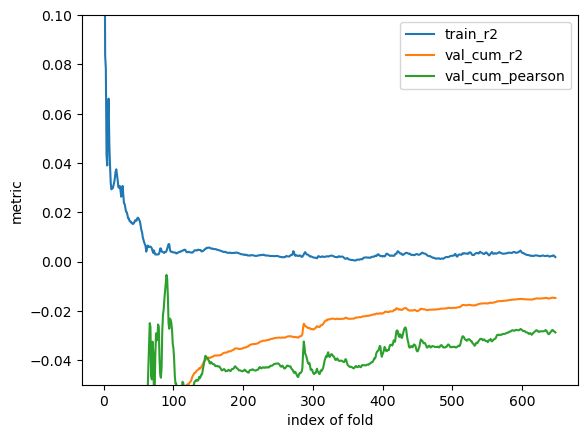

In [30]:
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.show()

In [24]:
evaluation_for_submission(linear_model, features, dataset_small, df_small, qids, lookback_window=200)

  0%|          | 0/700 [00:00<?, ?it/s]

day 1001
train feature
           turnoverRatio  transactionAmount   pe_ttm        pe      pb  \
day asset                                                                
800 0             0.6962             6013.0  23.1425  123.6629  1.8012   
    1             0.1666             2783.0  38.3419   39.4144  6.4031   
    2             0.8394            15626.0  49.5463   59.8699  7.9165   
    3             1.5553             4878.0  18.8519   17.7761  1.7440   
    4             0.8107             7019.0  37.9439   30.3294  2.3913   
...                  ...                ...      ...       ...     ...   
999 49            0.1903             3431.0  40.8371   40.8371  2.8123   
    50            0.3387             5516.0  19.5646   19.5646  2.5200   
    51            0.7134             3409.0  14.2094   14.2094  1.3759   
    52            0.4320             6273.0  28.4083   28.4083  5.6690   
    53            1.1675             6249.0  10.6633   10.6633  1.9979   

              